In [1]:
# Add local scripts to module search path
import sys
import os
sys.path.append(os.path.realpath('../toliman-proper'))

## Reference image from Zemax

Parabolic mirror RC with monochromatic 600nm on-axis source.

Data spacing is 1.875 µm.
Data area is 1920.027 by 1920.027 µm.
Center point is: 513, 513

In [2]:
import numpy as np
import os

# Source file location
datapath = '../zemax_examples/'
filename = 'toliman-RC-f50_SpiralPupil_psf_0deg_600nm_4mm.npy'

zemax_ref = np.load(datapath+filename)

In [3]:
print(zemax_ref.shape)

(1024, 1024)


### Adjust reference Zemax image

#### Resolution

Zemax renders its PSF at a resolution higher than that of the detector. I'll use the PROPER `prop_manify` function to rescale it to the correct resolution.

#### Dimensions

The reference and model images should match in size. In this particular case the rescaled reference image is smaller than the PSFs generated by PROPER, so I'll apply a viewport to the latter.

#### Normalised intensity

At present we're assuming that intensity scales are relative, so the reference and model intensities need to be aligned in some way. I'm going to normalise so that the total intensity is 1.0.


In [4]:
print("Data area {} by {} µm".format(zemax_ref.shape[0]*4,zemax_ref.shape[1]*4))

Data area 4096 by 4096 µm


In [5]:
print("Sized at 11µm pixels gives {} by {} µm".format(zemax_ref.shape[0]*4./11.,zemax_ref.shape[1]*4./11.))

Sized at 11µm pixels gives 372.3636363636364 by 372.3636363636364 µm


In [6]:
import proper
# Resolution is too high, so downsample.
src_pitch = 4e-6 # m/pixel
detector_pitch = 11.0e-6 # m/pixel on detector
npixels = 512 # Size of detector, in pixels

mag = src_pitch / detector_pitch
print("Rescaling from sampling of {} to {}, magnification of {}".format(src_pitch, detector_pitch, mag))
zemax_resized = proper.prop_magnify(zemax_ref, mag, CONSERVE = False, AMP_CONSERVE=False)

Rescaling from sampling of 4e-06 to 1.1e-05, magnification of 0.36363636363636365


/suphys/bjef8061/.local/lib/python3.5/site-packages/pyfits-3.5-py3.5-linux-x86_64.egg/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


(372, 372)


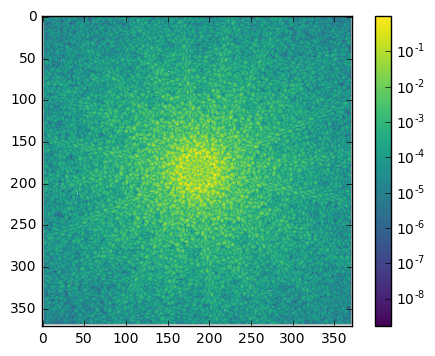

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
sz = zemax_resized.shape
print(sz)
plt.imshow(zemax_resized, cmap='viridis', norm=LogNorm())
plt.colorbar()
plt.show()

In [8]:
npixels = min(npixels, sz[0])

## Add Poisson noise

Scale image to have a peak of 25k to be below saturation, then add photon noise by drawing random values from a Poisson distribution.

In [9]:
intensity_scale = (25000/zemax_resized.max(axis=None))
detector_image = np.random.poisson(
    intensity_scale*np.clip(zemax_resized,0.,1.)
)

In [10]:
# Get lower bound on error
min_err = np.sum((detector_image - intensity_scale*zemax_resized)**2) 
print(min_err)

12975734.4573


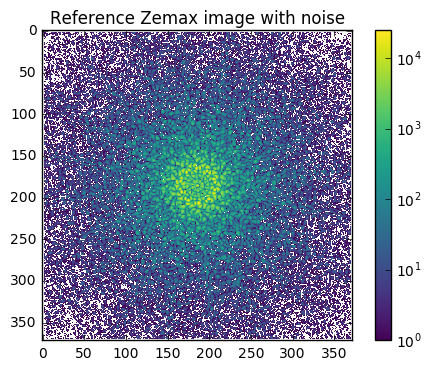

In [11]:
plt.imshow(detector_image, interpolation = 'none', cmap='viridis',norm=LogNorm())
plt.colorbar()
plt.title('Reference Zemax image with noise')
plt.show()

# Fit with Proper model by tweaking position and flux


In [12]:
from spirals import binarized_ringed_flipped

def binarized_ringed_650(r, phi):
    phase = 650.*1e-9*0.5
    return binarized_ringed_flipped(r, phi, phase)
beam_ratio = 0.4
toliman_settings = {
                    'diam': 0.001 * 2. * 150, 
                    'm1_fl': 571.7300 / 1000.,
                    'm1_m2_sep': 549.240/1000.,
                    'm2_fl': -23.3800/1000.,
                    'bfl': 590.000 / 1000., 
                    'm2_rad': 5.9 / 1000., 
                    'm2_strut_width': 0.01,
                    'm2_supports': 5,
                    'beam_ratio': beam_ratio,
                    'tilt_x': 0.00,
                    'tilt_y': 0.00,
                    'opd_func': binarized_ringed_650,
                    'm1_hole_rad':0.025,
                    'use_caching':True
                    }

gridsize = 2048 # sampling of wavefront
wavelength = 0.65 # micros
# First source, on axis
source = {
            'wavelengths': [wavelength],
            'weights': [1.],
            'settings': toliman_settings
            }


In [13]:
# Function to generate 
from proper_tools import form_detector_image
errors = []
def model_err(params, view=False):
    tiltx = params[0]
    tilty = params[1]
    flux = params[2]
    settings = toliman_settings.copy()
    settings['tilt_x'] = tiltx 
    settings['tilt_y'] = tilty
    source = {
            'wavelengths': [wavelength],
            'weights': [1.],
            'settings': settings
            }
    im = form_detector_image('prescription_rc_quad', [source], gridsize, detector_pitch, npixels)
    # Adjust scale
    im *= intensity_scale*flux
    if view:
        plt.imshow(im, interpolation = 'none', cmap='viridis',norm=LogNorm())
        plt.colorbar()
        #plt.title('Reference PROPER image with noise')
        plt.show()
    error = np.sum((im - detector_image)**2)
    errors.append((params,error))
    print('Error for offset ({:.2e},{:.2e}) and flux {:.2e}: {}% baseline '.format(tiltx, tiltx, flux, round(100.*error/min_err)))
    return error

## Optimize

In [14]:
from scipy.optimize import minimize
errors=[]
dir_init = [0.1, 0.1,0.8]
opt = minimize(model_err, dir_init, method='L-BFGS-B',
               bounds=[(-1.0,1.0),(-1.0,1.0),(0.5,1.5)])

Error for offset (1.00e-01,1.00e-01) and flux 8.00e-01: 419695.0% baseline 
Error for offset (1.00e-01,1.00e-01) and flux 8.00e-01: 419695.0% baseline 
Error for offset (1.00e-01,1.00e-01) and flux 8.00e-01: 419695.0% baseline 
Error for offset (1.00e-01,1.00e-01) and flux 8.00e-01: 419695.0% baseline 
Error for offset (1.00e+00,1.00e+00) and flux 1.50e+00: 419413.0% baseline 
Error for offset (1.00e+00,1.00e+00) and flux 1.50e+00: 419413.0% baseline 
Error for offset (1.00e+00,1.00e+00) and flux 1.50e+00: 419413.0% baseline 
Error for offset (1.00e+00,1.00e+00) and flux 1.50e+00: 419413.0% baseline 
Error for offset (6.02e-01,6.02e-01) and flux 1.50e+00: 419367.0% baseline 
Error for offset (6.02e-01,6.02e-01) and flux 1.50e+00: 419367.0% baseline 
Error for offset (6.02e-01,6.02e-01) and flux 1.50e+00: 419367.0% baseline 
Error for offset (6.02e-01,6.02e-01) and flux 1.50e+00: 419367.0% baseline 
Error for offset (7.50e-01,7.50e-01) and flux 1.50e+00: 419356.0% baseline 
Error for of

In [15]:
print(opt)

      fun: 54414341651.328178
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.28881836e+03,   7.62939453e+02,  -6.08711243e+07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 8
   status: 0
  success: True
        x: array([ 0.72011285,  0.99205697,  1.5       ])


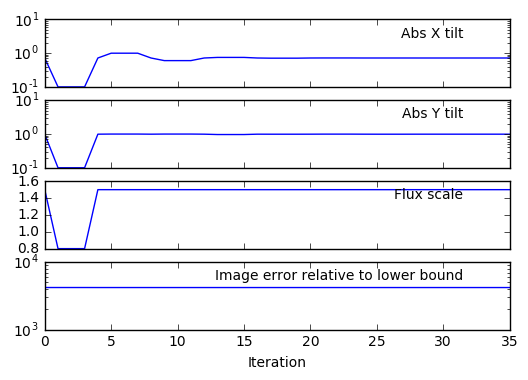

In [16]:
#Visualise the space explored by the optimiser
import matplotlib.pyplot as plt
import math

(I,X,Y,F,E) = zip(*[(i,abs(dx),abs(dy),df,e/min_err) for i,((dx,dy,df),e) in enumerate(errors)])

f, axes = plt.subplots(4, sharex=True)
axes[0].plot(I, X)
axes[0].text(.9,.9,'Abs X tilt',
        horizontalalignment='right', verticalalignment='top',
        transform=axes[0].transAxes)
axes[0].locator_params(axis='y', nbins=6)
axes[0].set_yscale('log')
axes[1].plot(I, Y)
axes[1].text(.9,.9,'Abs Y tilt',
        horizontalalignment='right', verticalalignment='top',
        transform=axes[1].transAxes)
axes[1].locator_params(axis='y', nbins=6)
axes[1].set_yscale('log')
axes[2].plot(I, F)
axes[2].text(.9,.9,'Flux scale',
        horizontalalignment='right', verticalalignment='top',
        transform=axes[2].transAxes)
axes[2].locator_params(axis='y', nbins=6)
axes[3].plot(I, E)
axes[3].text(.9,.9,'Image error relative to lower bound',
        horizontalalignment='right', verticalalignment='top',
        transform=axes[3].transAxes)
axes[3].locator_params(axis='y', nbins=6)
axes[3].set_yscale('log')
axes[3].set_xlabel('Iteration')
plt.show()

### Minimise close to expected location

In [24]:
# Repeat closer to expected location
from scipy.optimize import minimize
errors=[]
dir_init = [0.001, 0.01,1.0]
opt = minimize(model_err, dir_init, method='L-BFGS-B',
               bounds=[(-1.0,1.0),(-1.0,1.0),(0.5,1.5)])

Error for offset (1.00e-03,1.00e-03) and flux 1.00e+00: 2.0% baseline 
Error for offset (1.00e-03,1.00e-03) and flux 1.00e+00: 2.0% baseline 
Error for offset (1.00e-03,1.00e-03) and flux 1.00e+00: 2.0% baseline 
Error for offset (1.00e-03,1.00e-03) and flux 1.00e+00: 2.0% baseline 
Error for offset (-1.00e+00,-1.00e+00) and flux 5.00e-01: 2.0% baseline 
Error for offset (-1.00e+00,-1.00e+00) and flux 5.00e-01: 2.0% baseline 
Error for offset (-1.00e+00,-1.00e+00) and flux 5.00e-01: 2.0% baseline 
Error for offset (-1.00e+00,-1.00e+00) and flux 5.00e-01: 2.0% baseline 
Error for offset (-1.00e+00,-1.00e+00) and flux 5.70e-01: 2.0% baseline 
Error for offset (-1.00e+00,-1.00e+00) and flux 5.70e-01: 2.0% baseline 
Error for offset (-1.00e+00,-1.00e+00) and flux 5.70e-01: 2.0% baseline 
Error for offset (-1.00e+00,-1.00e+00) and flux 5.70e-01: 2.0% baseline 
Error for offset (-1.00e+00,-1.00e+00) and flux 5.91e-01: 2.0% baseline 
Error for offset (-1.00e+00,-1.00e+00) and flux 5.91e-01: 2

In [25]:
print(opt)

      fun: 201655.3897798761
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  8.17736727e+03,   2.37147091e+04,  -8.73114914e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 20
      nit: 4
   status: 0
  success: True
        x: array([-1.        , -1.        ,  0.59105697])


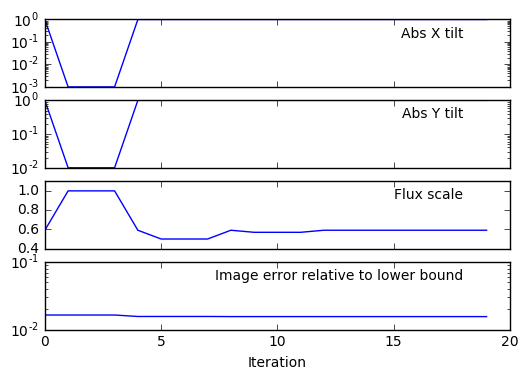

In [26]:
#Visualise the space explored by the optimiser
import matplotlib.pyplot as plt
import math

(I,X,Y,F,E) = zip(*[(i,abs(dx),abs(dy),df,e/min_err) for i,((dx,dy,df),e) in enumerate(errors)])

f, axes = plt.subplots(4, sharex=True)
axes[0].plot(I, X)
axes[0].text(.9,.9,'Abs X tilt',
        horizontalalignment='right', verticalalignment='top',
        transform=axes[0].transAxes)
axes[0].locator_params(axis='y', nbins=6)
axes[0].set_yscale('log')
axes[1].plot(I, Y)
axes[1].text(.9,.9,'Abs Y tilt',
        horizontalalignment='right', verticalalignment='top',
        transform=axes[1].transAxes)
axes[1].locator_params(axis='y', nbins=6)
axes[1].set_yscale('log')
axes[2].plot(I, F)
axes[2].text(.9,.9,'Flux scale',
        horizontalalignment='right', verticalalignment='top',
        transform=axes[2].transAxes)
axes[2].locator_params(axis='y', nbins=6)
axes[3].plot(I, E)
axes[3].text(.9,.9,'Image error relative to lower bound',
        horizontalalignment='right', verticalalignment='top',
        transform=axes[3].transAxes)
axes[3].locator_params(axis='y', nbins=6)
axes[3].set_yscale('log')
axes[3].set_xlabel('Iteration')
plt.show()

In [27]:
settings = toliman_settings.copy()
settings['tilt_x'] = opt.x[0] 
settings['tilt_y'] = opt.x[1]
source = {
        'wavelengths': [wavelength],
        'weights': [1.],
        'settings': settings
        }
# How do things look now?
detector_image = form_detector_image('prescription_rc_quad', [source], gridsize, detector_pitch, npixels)
detector_image *= intensity_scale*opt.x[2]

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import numpy as np
def view_psf(imarray, pitch_mm, viewport_mm,vmin=None,vmax=None,title=None):
    c = imarray.shape[0]/2. # Assume scaled image
    w = viewport_mm/pitch_mm
    im = plt.imshow(imarray[int(c-w):int(c+w),int(c-w):int(c+w)],cmap='viridis', extent=[x*pitch_mm for x in [-w,w,-w,w]], norm=LogNorm(),vmin=vmin, vmax=vmax)
    if title is not None:
        plt.title(title)
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

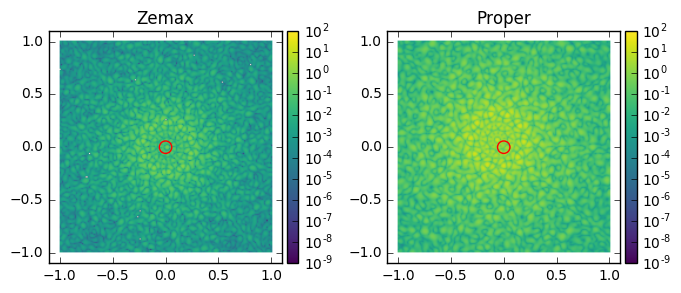

In [37]:
#Side by side plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
fig, axes = plt.subplots(1, 2, figsize=(8,3))
plt.axes(axes[0])
view_psf(zemax_resized, detector_pitch/1e-3, 1., vmin=1e-9, vmax=1e2, title='Zemax')
axes[0].scatter([0], [0], s=80, facecolors='none', edgecolors='r')

plt.axes(axes[1])
view_psf(detector_image, detector_pitch/1e-3, 1., vmin=1e-9, vmax=1e2, title='Proper')
axes[1].scatter([0], [0], s=80, facecolors='none', edgecolors='r')
plt.show()